# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Multiple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from ML_Regression import ML_Regression
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


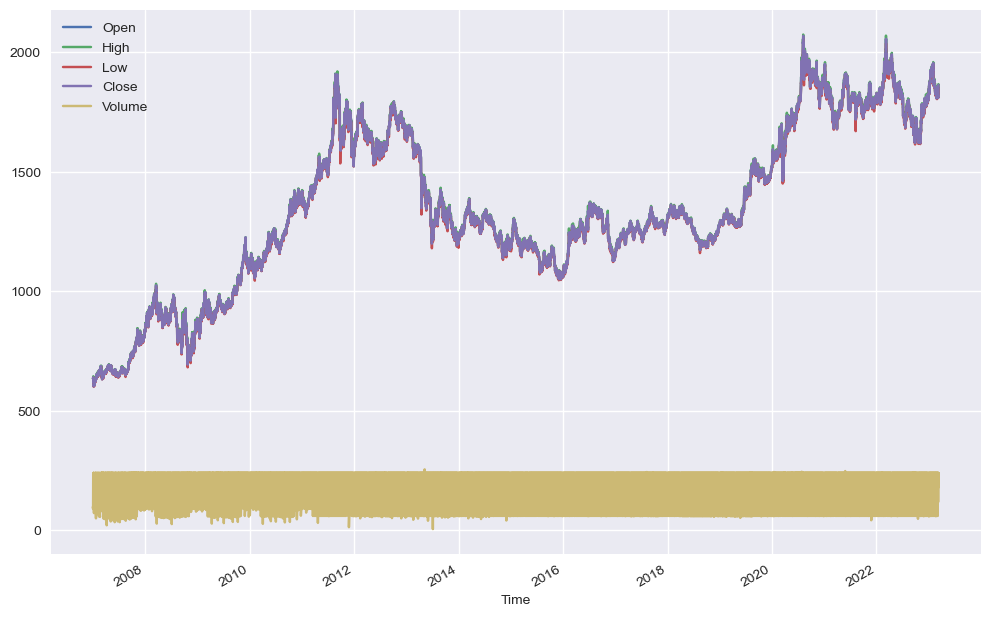

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [6]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [7]:
strategy = Mutiple_Regression
account_size = 2000

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=2000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        filename_train = f'result_{self.TF}_In_Sample.csv'
        filepath_train = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/train.csv'
        # self.Save_Result(result_train, filepath_train)


        self.Predict()
        result_test = self.Backtest(self.data_test)
        filename_test = f'result_{self.TF}_Out_Sample.csv'
        filepath_test = f'../../out/Machine_Learning/Multiple_Linear_Regression/Backtest/test.csv'
        # self.Save_Result(result_test, filepath_test)

        return result_train, result_test

## TF D1

In [10]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'D1'

In [11]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [12]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_5172\1996948212.py:68: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_5172\1996948212.py:68: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [13]:
train

Start                     2007-01-08 00:00:00
End                       2020-12-30 00:00:00
Duration                   5105 days 00:00:00
Exposure Time [%]                   99.954097
Equity Final [$]                     3376.971
Equity Peak [$]                      3386.431
Return [%]                           68.84855
Buy & Hold Return [%]                211.0994
Return (Ann.) [%]                    3.076101
Volatility (Ann.) [%]                7.618869
Sharpe Ratio                         0.403748
Sortino Ratio                        0.589982
Calmar Ratio                         0.130234
Max. Drawdown [%]                  -23.619719
Avg. Drawdown [%]                   -1.746091
Max. Drawdown Duration     2659 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                 1273
Win Rate [%]                        51.688924
Best Trade [%]                      10.617556
Worst Trade [%]                    -11.108864
Avg. Trade [%]                    

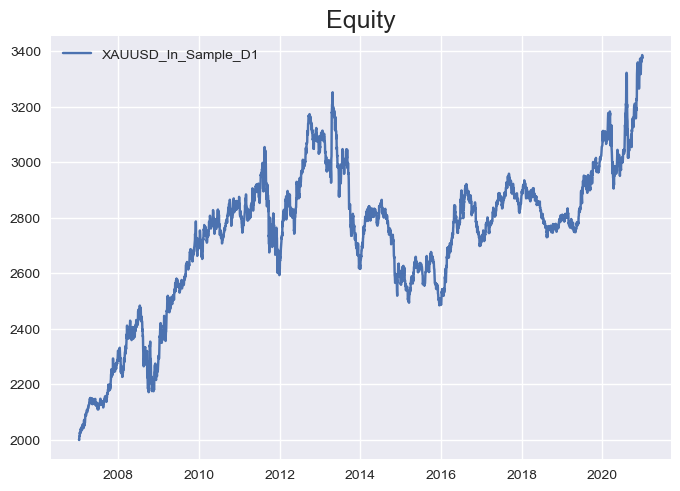

In [14]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [15]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                     2005.951
Equity Peak [$]                      2426.169
Return [%]                            0.29755
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                     0.07604
Volatility (Ann.) [%]               12.653814
Sharpe Ratio                         0.006009
Sortino Ratio                        0.008334
Calmar Ratio                         0.003171
Max. Drawdown [%]                  -23.978379
Avg. Drawdown [%]                   -4.135644
Max. Drawdown Duration      404 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                                  300
Win Rate [%]                             48.0
Best Trade [%]                       5.671401
Worst Trade [%]                     -5.389095
Avg. Trade [%]                    

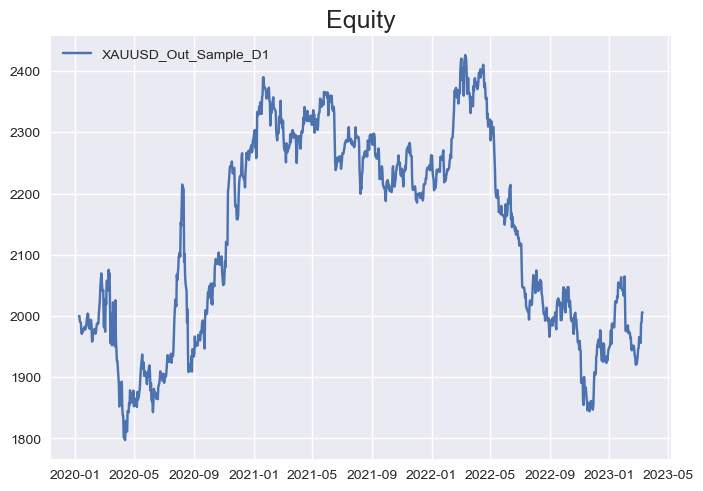

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [26]:
train

Start                     2007-01-02 00:00:00
End                       2020-12-31 20:00:00
Duration                   5112 days 20:00:00
Exposure Time [%]                   99.991099
Equity Final [$]                      2588.77
Equity Peak [$]                      2952.182
Return [%]                            29.4385
Buy & Hold Return [%]              197.773172
Return (Ann.) [%]                    1.500204
Volatility (Ann.) [%]                 8.90482
Sharpe Ratio                         0.168471
Sortino Ratio                        0.249064
Calmar Ratio                          0.04279
Max. Drawdown [%]                  -35.059627
Avg. Drawdown [%]                   -1.174543
Max. Drawdown Duration     3038 days 20:00:00
Avg. Drawdown Duration       40 days 09:00:00
# Trades                                 8019
Win Rate [%]                        50.455169
Best Trade [%]                       7.563357
Worst Trade [%]                     -7.421416
Avg. Trade [%]                    

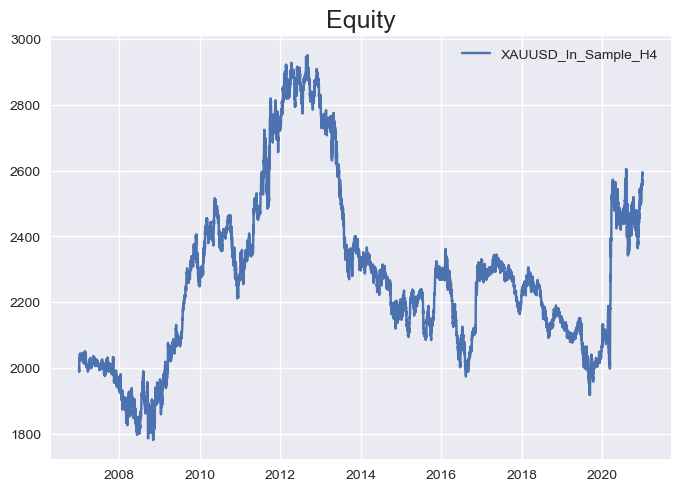

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                      2354.84
Equity Peak [$]                      2696.246
Return [%]                             17.742
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                    4.245008
Volatility (Ann.) [%]               11.732968
Sharpe Ratio                         0.361802
Sortino Ratio                        0.546861
Calmar Ratio                         0.212574
Max. Drawdown [%]                   -19.96958
Avg. Drawdown [%]                   -1.878404
Max. Drawdown Duration      367 days 08:00:00
Avg. Drawdown Duration       24 days 12:00:00
# Trades                                 1799
Win Rate [%]                        52.306837
Best Trade [%]                        4.16845
Worst Trade [%]                     -5.873167
Avg. Trade [%]                    

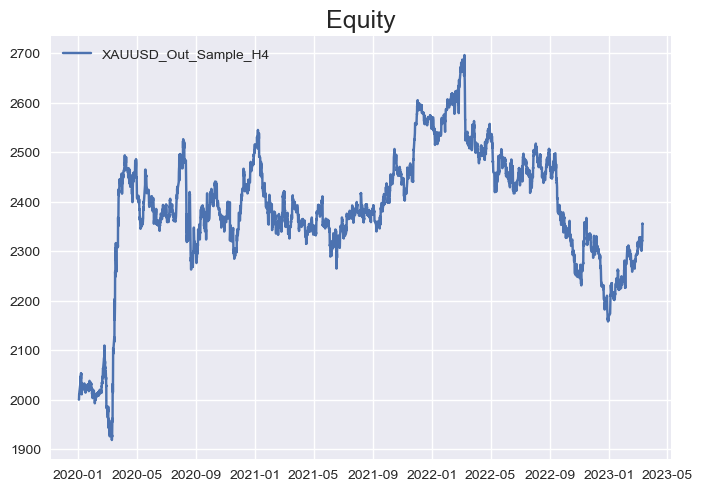

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 06:00:00
End                       2020-12-31 21:00:00
Duration                   5113 days 15:00:00
Exposure Time [%]                   99.997647
Equity Final [$]                     3417.758
Equity Peak [$]                      3603.073
Return [%]                            70.8879
Buy & Hold Return [%]              198.538115
Return (Ann.) [%]                    3.142087
Volatility (Ann.) [%]                7.464507
Sharpe Ratio                         0.420937
Sortino Ratio                        0.620836
Calmar Ratio                         0.237184
Max. Drawdown [%]                  -13.247468
Avg. Drawdown [%]                   -0.649296
Max. Drawdown Duration      959 days 21:00:00
Avg. Drawdown Duration       14 days 06:00:00
# Trades                                24309
Win Rate [%]                        52.795261
Best Trade [%]                       5.743715
Worst Trade [%]                     -6.950814
Avg. Trade [%]                    

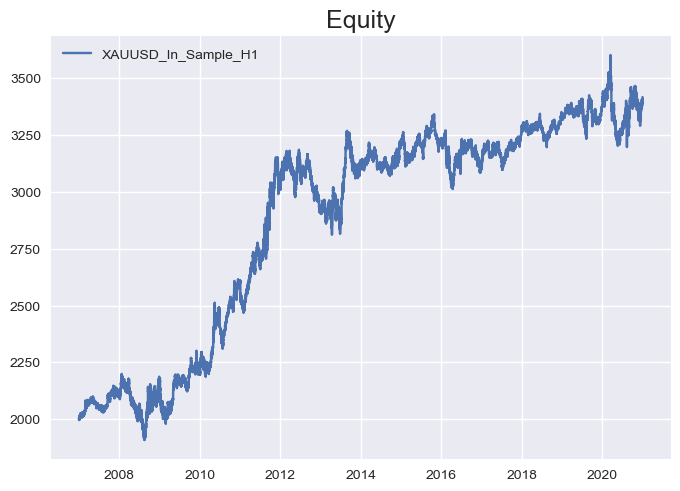

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                     1899.264
Equity Peak [$]                      2229.491
Return [%]                            -5.0368
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   -1.335124
Volatility (Ann.) [%]               12.545624
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.225918
Avg. Drawdown [%]                   -2.064667
Max. Drawdown Duration      653 days 05:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                 5534
Win Rate [%]                        52.800867
Best Trade [%]                       3.192889
Worst Trade [%]                     -6.474645
Avg. Trade [%]                    

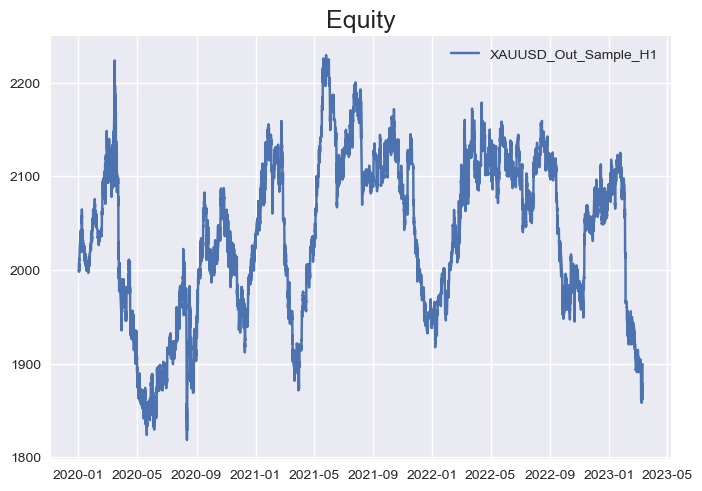

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 03:00:00
End                       2020-12-31 21:30:00
Duration                   5113 days 18:30:00
Exposure Time [%]                   99.998819
Equity Final [$]                     3980.015
Equity Peak [$]                      3982.893
Return [%]                           99.00075
Buy & Hold Return [%]              198.631601
Return (Ann.) [%]                    4.060261
Volatility (Ann.) [%]                7.165669
Sharpe Ratio                         0.566627
Sortino Ratio                        0.853574
Calmar Ratio                         0.193409
Max. Drawdown [%]                  -20.993113
Avg. Drawdown [%]                   -0.362008
Max. Drawdown Duration     2642 days 01:30:00
Avg. Drawdown Duration        7 days 14:11:00
# Trades                                63632
Win Rate [%]                        52.776905
Best Trade [%]                       4.383939
Worst Trade [%]                     -4.759791
Avg. Trade [%]                    

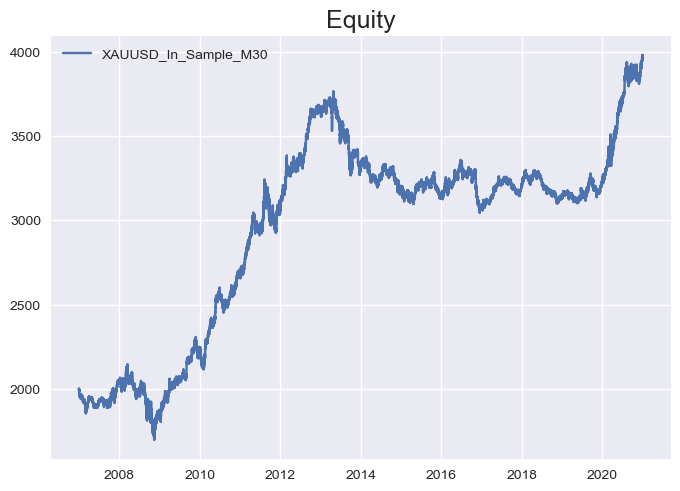

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     2992.903
Equity Peak [$]                      3078.588
Return [%]                           49.64515
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   10.620149
Volatility (Ann.) [%]               11.177147
Sharpe Ratio                         0.950166
Sortino Ratio                        1.545398
Calmar Ratio                         0.993722
Max. Drawdown [%]                  -10.687241
Avg. Drawdown [%]                   -0.492385
Max. Drawdown Duration      341 days 00:30:00
Avg. Drawdown Duration        4 days 01:01:00
# Trades                                14714
Win Rate [%]                        52.874813
Best Trade [%]                       2.845167
Worst Trade [%]                     -4.759791
Avg. Trade [%]                    

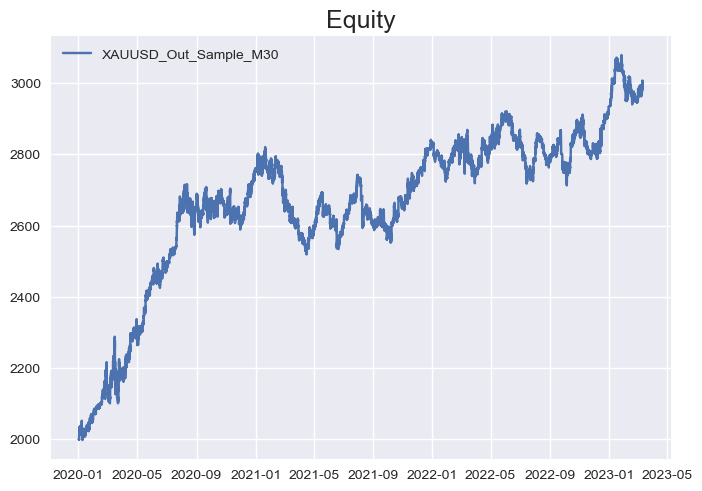

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2020'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 14:30:00
End                       2020-12-31 21:45:00
Duration                   2291 days 07:15:00
Exposure Time [%]                   99.998651
Equity Final [$]                     2638.128
Equity Peak [$]                      2741.348
Return [%]                            31.9064
Buy & Hold Return [%]                55.35929
Return (Ann.) [%]                    3.615462
Volatility (Ann.) [%]                7.761801
Sharpe Ratio                         0.465802
Sortino Ratio                        0.693516
Calmar Ratio                         0.237288
Max. Drawdown [%]                  -15.236628
Avg. Drawdown [%]                   -0.373912
Max. Drawdown Duration     1321 days 02:45:00
Avg. Drawdown Duration        6 days 00:17:00
# Trades                                68016
Win Rate [%]                        52.152435
Best Trade [%]                       2.481729
Worst Trade [%]                     -2.513293
Avg. Trade [%]                    

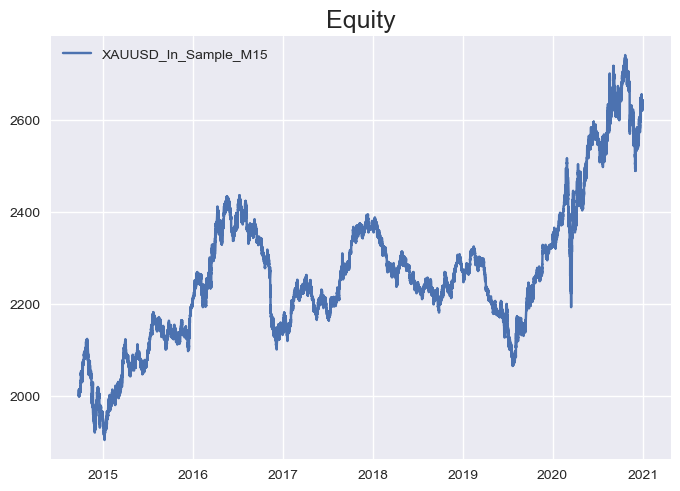

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2480.449
Equity Peak [$]                      2665.173
Return [%]                           24.02245
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                    5.567672
Volatility (Ann.) [%]               11.776608
Sharpe Ratio                         0.472774
Sortino Ratio                        0.725466
Calmar Ratio                         0.362783
Max. Drawdown [%]                  -15.347109
Avg. Drawdown [%]                   -0.541963
Max. Drawdown Duration      283 days 19:15:00
Avg. Drawdown Duration        4 days 02:38:00
# Trades                                34894
Win Rate [%]                        51.836992
Best Trade [%]                       1.535251
Worst Trade [%]                     -2.894386
Avg. Trade [%]                    

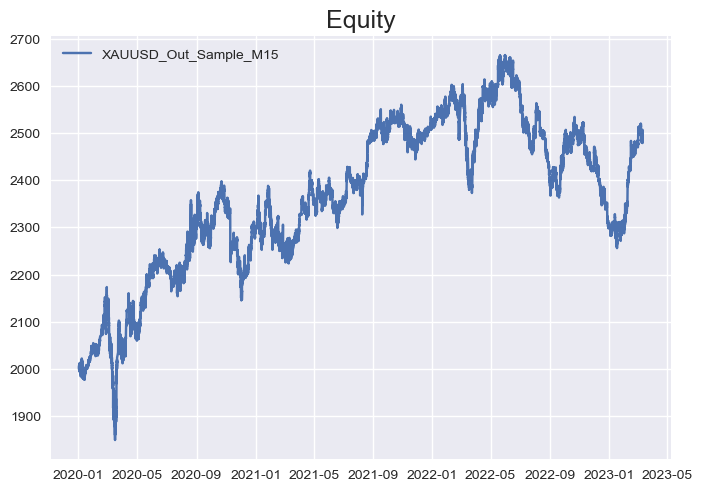

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [65]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [66]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M5

In [67]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M5'

In [68]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [69]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_11108\2818259696.py:67: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [70]:
train

Start                     2020-05-15 11:40:00
End                       2023-03-10 17:55:00
Duration                   1029 days 06:15:00
Exposure Time [%]                      99.999
Equity Final [$]                     2735.474
Equity Peak [$]                      2773.163
Return [%]                            36.7737
Buy & Hold Return [%]                   7.591
Return (Ann.) [%]                     9.77735
Volatility (Ann.) [%]               12.115811
Sharpe Ratio                         0.806991
Sortino Ratio                        1.256151
Calmar Ratio                         0.737571
Max. Drawdown [%]                  -13.256144
Avg. Drawdown [%]                   -0.262499
Max. Drawdown Duration      490 days 08:40:00
Avg. Drawdown Duration        1 days 20:07:00
# Trades                               113152
Win Rate [%]                        51.441424
Best Trade [%]                       1.030794
Worst Trade [%]                     -3.754972
Avg. Trade [%]                    

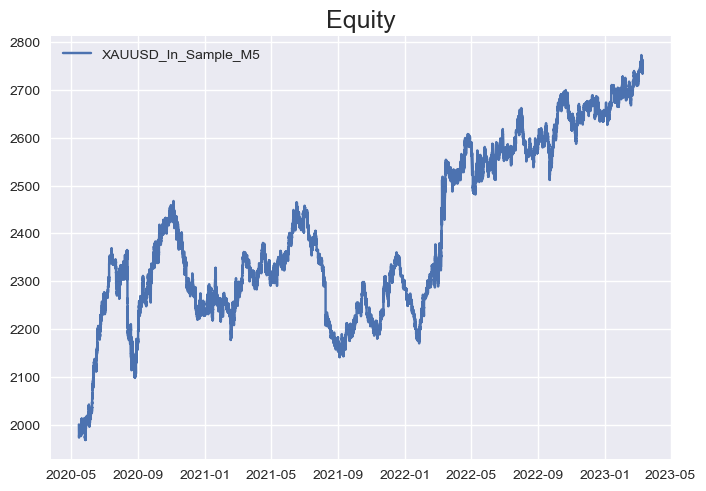

In [71]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [72]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     2071.471
Equity Peak [$]                       2109.16
Return [%]                            3.57355
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                   15.958277
Volatility (Ann.) [%]               11.346282
Sharpe Ratio                         1.406476
Sortino Ratio                         2.51816
Calmar Ratio                          5.46464
Max. Drawdown [%]                    -2.92028
Avg. Drawdown [%]                   -0.268383
Max. Drawdown Duration       20 days 03:20:00
Avg. Drawdown Duration        0 days 20:28:00
# Trades                                 7610
Win Rate [%]                        51.681997
Best Trade [%]                       0.753041
Worst Trade [%]                     -1.404384
Avg. Trade [%]                    

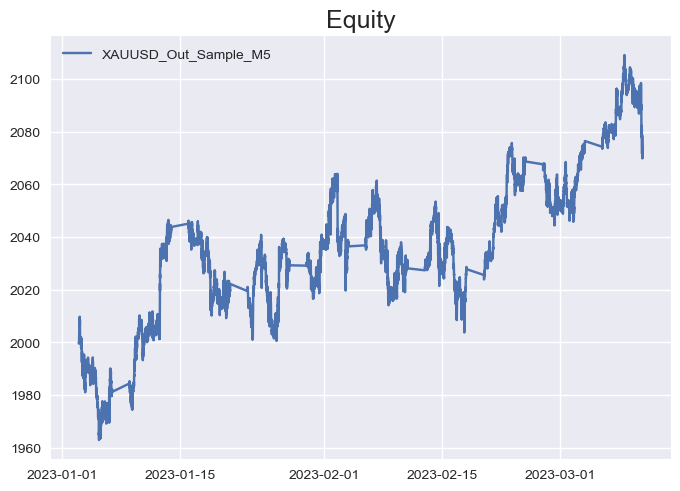

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [74]:
filename_train = f'result_{TF}_In_Sample.csv'

In [75]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [76]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [77]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')

## TF M1

In [78]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2023'
end_test = '2023'
TF = 'M1'

In [79]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [80]:
train , test = ml.Run()

### In-Sample Backtesting

In [81]:
train

Start                     2022-08-16 23:19:00
End                       2023-03-10 17:59:00
Duration                    205 days 18:40:00
Exposure Time [%]                      99.999
Equity Final [$]                      2501.08
Equity Peak [$]                      2524.279
Return [%]                             25.054
Buy & Hold Return [%]                4.985419
Return (Ann.) [%]                    37.61453
Volatility (Ann.) [%]               14.364728
Sharpe Ratio                         2.618534
Sortino Ratio                        6.446429
Calmar Ratio                         5.208005
Max. Drawdown [%]                   -7.222445
Avg. Drawdown [%]                    -0.10653
Max. Drawdown Duration       55 days 12:19:00
Avg. Drawdown Duration        0 days 05:58:00
# Trades                                72621
Win Rate [%]                        52.833203
Best Trade [%]                       0.933864
Worst Trade [%]                      -1.11057
Avg. Trade [%]                    

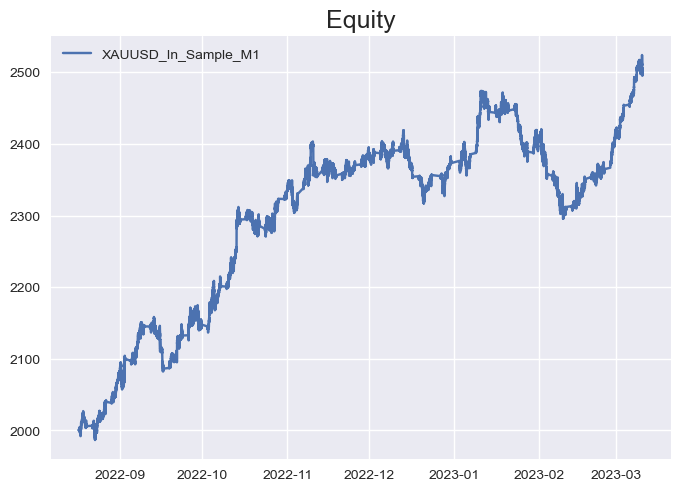

In [82]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [83]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                     2128.335
Equity Peak [$]                      2151.534
Return [%]                            6.41675
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                   31.675208
Volatility (Ann.) [%]                15.45387
Sharpe Ratio                         2.049662
Sortino Ratio                        4.840848
Calmar Ratio                         3.724966
Max. Drawdown [%]                   -8.503488
Avg. Drawdown [%]                   -0.138362
Max. Drawdown Duration       55 days 12:19:00
Avg. Drawdown Duration        0 days 08:08:00
# Trades                                24371
Win Rate [%]                        52.546059
Best Trade [%]                       0.708517
Worst Trade [%]                      -0.92513
Avg. Trade [%]                    

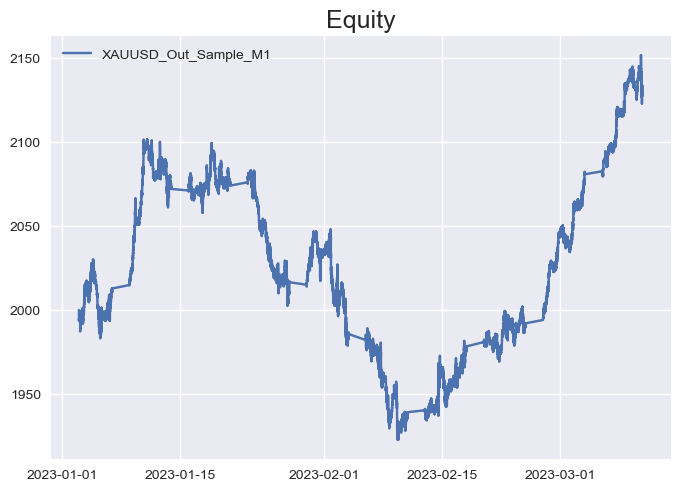

In [84]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [85]:
filename_train = f'result_{TF}_In_Sample.csv'

In [86]:
save_to_csv(train, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/Mutiple_Linear_Regression/Backtest/{filename_test}')